In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image


In [2]:

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.32.3
BeautifulSoup   4.12.3


In [3]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [4]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [5]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [6]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [7]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [8]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [9]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [10]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


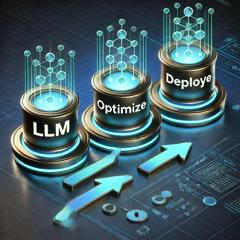

[A primer on inference optimization and LLM acceleration](https://hackernoon.com/primer-on-large-language-model-llm-inference-optimizations-1-background-and-problem-formulation?ref=hackernoon.com)

___

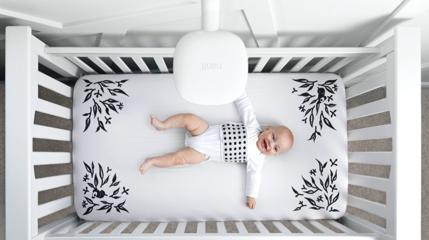

[AI-powered baby monitoring. How long til you can leave your kid with an AI babysitter than can play with it and sound an alarm if it gets upset or tries to do something dangerous?](https://techcrunch.com/2024/11/07/ai-powered-parenting-is-here-and-a16z-is-ready-to-back-it/) - TechCrunch

___

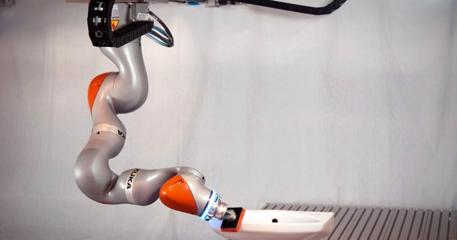

[Teaching a robot to clean a sink with imitation learning.](https://newatlas.com/robotics/robot-cleans-sink/) - New Atlas

___

The semiconductor business is cyclical and hit-driven, doesn't take much for one generation's leader to become the next generation's also-ran. As Nvidia rose and Intel fell, someone else can rise in the next generation.

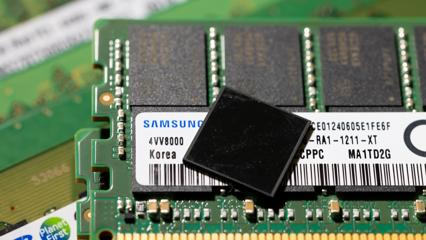

[How SK Hynix beat Samsung in GPU memory](https://www.cnbc.com/2024/11/08/how-samsung-fell-behind-in-the-ai-boom-behind-rival-sk-hynix.html) - CNBC

___

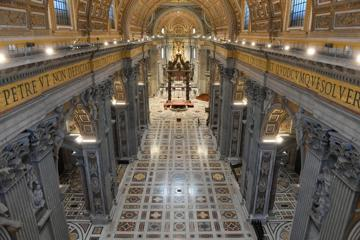

[“The Basilica of St. Peter’s: AI-Enhanced Experience” from Microsoft](https://www.catholicnewsagency.com/news/260329/microsoft-president-to-unveil-ai-enhanced-experience-of-st-peter-s-basilica) - Catholic News Agency

___

[Create a McKinsey-style deck in no time with Napkin](https://www.geeky-gadgets.com/text-into-stunning-visuals-ai-tools/)

___

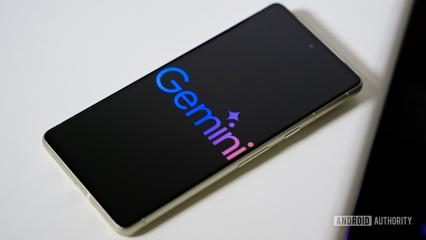

[The promise of AI assistants in your corporate environment is there, but not fully realized. Often faster to search the old-fashioned way and make changes yourself than ask the assistant.](https://www.androidauthority.com/ditched-chatgpt-for-gemini-3497814/) - Android Authority

___

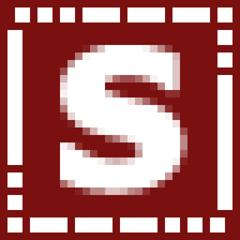

[Schneier: AI Industry is Trying to Subvert the Definition of “Open Source AI”

Meta's Llama license is limited and they can fully close it and hold you hostage for updates at any time.](https://www.schneier.com/blog/archives/2024/11/ai-industry-is-trying-to-subvert-the-definition-of-open-source-ai.html) - Schneier on Security

___

[Baidu Readies AI Smart Glasses to Rival Meta’s Ray-Bans](https://www.bloomberg.com/news/articles/2024-11-08/baidu-ai-smart-glasses-to-rival-meta-s-ray-bans-coming-at-baidu-world)

___

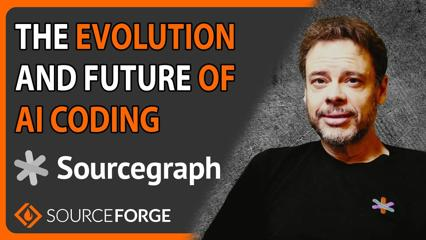

[Steve Yegge says non-AI assisted programming will go away like C ended most assembly language programming](https://www.youtube.com/watch?v=HVyVpIq1Pp8) - YouTube

___

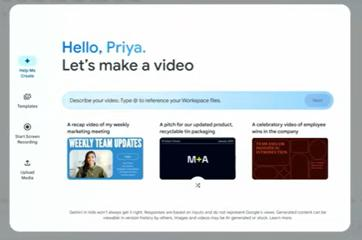

[Google's rolls out Vids AI video maker to most Workspace tiers](https://www.engadget.com/ai/googles-vids-ai-video-maker-is-rolling-out-to-most-workspace-tiers-223647949.html) - Engadget

___

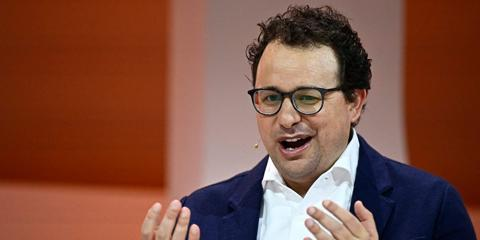

[Anthropic is gaining on OpenAI in use for coding](https://www.businessinsider.com/anthropic-gaining-on-openai-ai-market-2024-11) - Business Insider

___

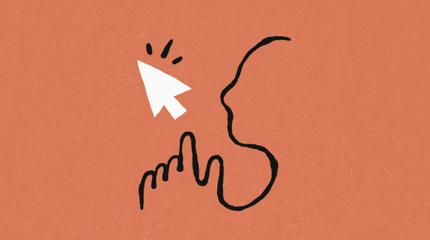

[Amazon reportedly mulls another multibillion-dollar investment in Anthropic, with Anthropic committing to use Amazon cloud and AI chips.](https://siliconangle.com/2024/11/07/amazon-reportedly-mulling-another-multibillion-dollar-investment-anthropic-added-twist/) - SiliconANGLE

___

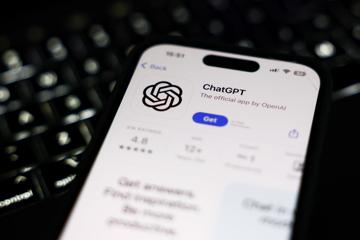

[OpenAI wins a round in copyright case](https://www.engadget.com/ai/openai-wins-first-round-against-raw-story-and-alternet-copyright-case-130027681.html) - Engadget

___

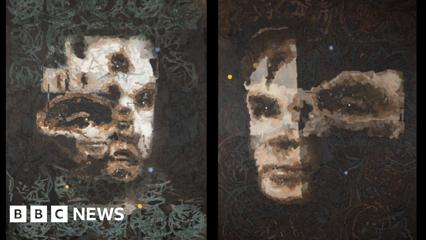

[AI-Da Robot artwork of Alan Turing sells for \\$1m at auction](https://www.bbc.com/news/articles/cpqdvz4w45wo)

___

[Go ahead, tattoo Nvidia on your body, I dare you](https://cointelegraph.com/news/novogratz-says-luna-tattoo-is-a-constant-reminder-investing-requires-humility)

___

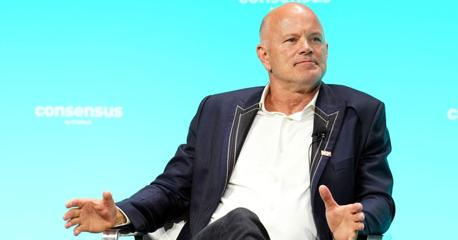

[Michael Novogratz's Pivots from Bitcoin to AI.](https://www.coindesk.com/business/2024/11/07/michael-novogratzs-galaxy-looks-to-turn-bitcoin-mining-into-ai-computing-as-revenue-falls/)

___

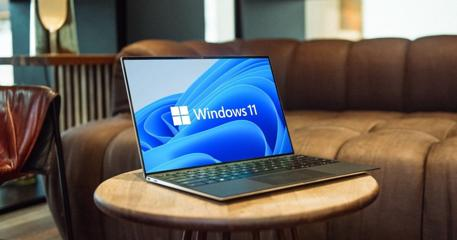

[Microsoft Paint and Notepad get more AI](https://www.digitaltrends.com/computing/amazing-ai-features-for-paint-and-notepad-apps-on-windows-11/) - Digital Trends

___

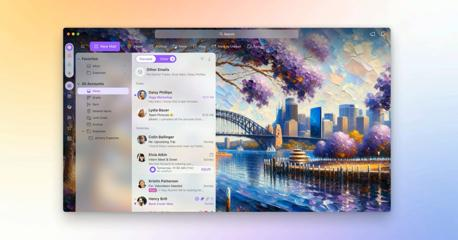

[Outlook gets AI themes](https://www.theverge.com/2024/11/7/24290273/microsoft-outlook-ai-themes-copilot) - The Verge

___

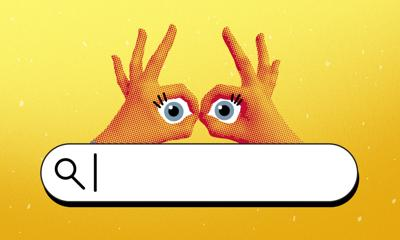

[Educating Students to Know About AI Misinformation: A Primer for Teachers](https://www.edweek.org/technology/opinion-what-to-know-about-ai-misinformation-a-primer-for-teachers-downloadable/2024/11) - Education Week

___

[Reddit user says ChatGPT saved his life.](https://www.reddit.com/r/ChatGPT/comments/1glqv2o/chatgpt_saved_my_life_and_im_still_freaking_out/)

___

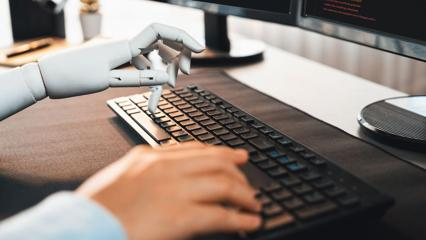

[ChatGPT coded a game for me in seconds and I am simply astounded – and coders should be very worried. But, (if it's the same game as earlier and a correct program was published, it might be in the training data.)](https://www.techradar.com/computing/artificial-intelligence/chatgpt-coded-a-game-for-me-in-seconds-and-i-am-simply-astounded-and-coders-should-be-very-worried) - TechRadar

___

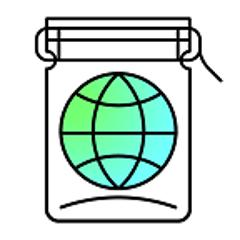

[mad science experiment: what would happen if I spent a year without Prime and shopped at Costco and Walmart and Temu and DHgate 🤔 not that they are so great LOL. what would happen if I wrote an automation to defeat the NYT paywall by prepending archive.is to the current URL whenever I hit ctrl-A 🤔 .](https://archive.is/) - archive.is

___

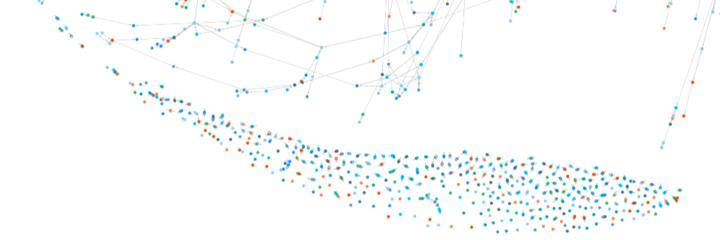

[Ha, some moderation lists you can block. Hasn't been a problem for me so far but good to keep in mind. bsky.app/profile/skyw... . if there is something similar for blocking crypto dweebs drop it in the comment . I am on some AI block lists lol. more power to'em.](https://bsky.app/profile/skywatch.blue) - Bluesky Social

___

name 'httplib' is not defined


[The implicit 'world model' in an LLM is inconsistent and brittle. arxiv.org/abs/2406.03689](https://arxiv.org/abs/2406.03689) - arXiv.org

___

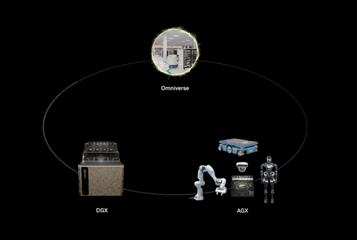

[Nvidia's platform to build robots.](https://roboticsandautomationnews.com/2024/11/05/the-three-computer-solution-powering-the-next-wave-of-ai-robotics/86816/) - Robotics & Automation News

___

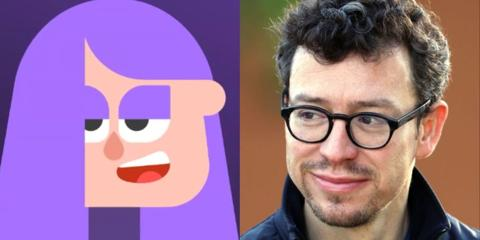

[Duolingo had its sarcastic teen chatbot deliver financials on earnings call](https://www.businessinsider.com/duolingo-ai-chatbot-lily-earnings-call-daily-active-users-app-2024-11) - Business Insider

___

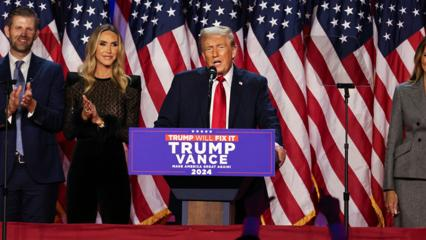

[Trump's plans to dismantle AI guardrails](https://arstechnica.com/ai/2024/11/trump-victory-signals-major-shakeup-for-us-ai-regulations/) - Ars Technica

___

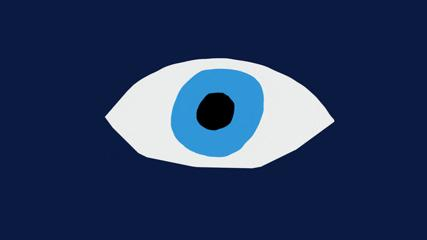

[Special Report: The Future of AI. The doctors pioneering the use of AI to improve outcomes for patients.](https://www.ft.com/content/2fd63023-ec0a-421c-9abb-b6c8000b3b51)

___

[FERC rejects power deal for nuclear Amazon datacenters. Now you know why Bezos's Washington Post declined to endorse Harris, among a few billion reasons.](https://www.theregister.com/2024/11/04/aws_nuclear_datacenter_ferc/)

___

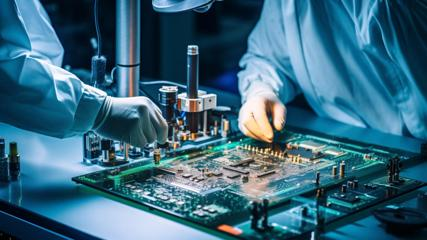

[Is Intel Corporation (INTC) Ready for a Comeback in the AI Chip Market? Is Musk/Trump Administration going to nix rescue payouts?](https://finance.yahoo.com/news/intel-corporation-intc-ready-comeback-130021865.html) - Yahoo Finance

___

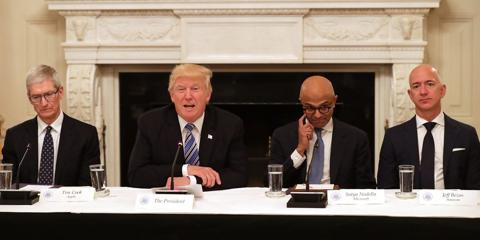

[Big Tech won't have to worry about Lina Khan and antitrust anymore.](https://fortune.com/2024/11/06/trump-2-0-will-have-a-massive-impact-on-big-tech-ai-chips-and-more-in-silicon-valley-and-beyond/) - Fortune

___

[An AI-powered drowning prevention system detects distressed swimmers in the water, notifies rescuers, dispatches robot buoyancy devices for swimmers to hang onto.](https://techxplore.com/news/2024-11-ai-powered-safety.html)

___

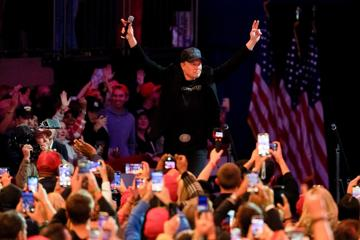

[More on what Trump’s win might mean for Elon Musk that I'm too disgusted to read.](https://techcrunch.com/2024/11/06/what-trumps-win-might-mean-for-elon-musk/) - TechCrunch

___

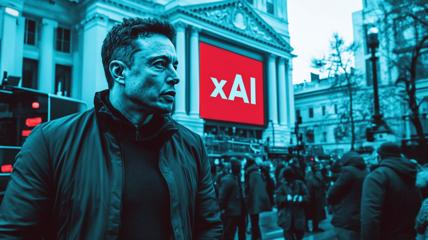

[Trump’s victory expected to benefit Elon Musk's businesses. He said OpenAI was rent-seeking by looking for regulatory clarity, and I'm sure xAI wouldn't do anything like that.](https://venturebeat.com/ai/trumps-victory-will-benefit-elon-musk-and-xai/) - VentureBeat

___

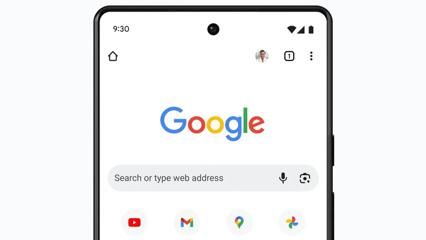

[Google briefly leaked a preview of its Jarvis AI that can take over computers. Possibly they intended to publish something internally in Chrome store but it was available to the public.](https://www.engadget.com/ai/google-accidentally-leaked-a-preview-of-its-jarvis-ai-that-can-take-over-computers-203125686.html?guccounter=1) - Engadget

___

[chat.com now redirects to chatgpt.com](https://chatgpt.com/)

___

Japan has launched the first satellite constructed from wood, the 'Country Squire'

Canceled NYT because I can’t deal with another four years of Maggie Haberman normalizing Argentina shit.

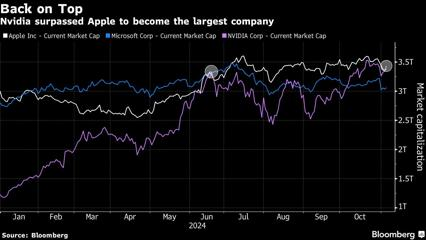

[Nvidia Passes Apple Again as World’s Largest Company](https://finance.yahoo.com/news/nvidia-rides-ai-wave-pass-211002055.html) - Yahoo Finance

___

"I asked ChatGPT what reddit users will look like in 30 years" - via Reddit

"I asked ChatGPT what humanity will look like in 30 years." -via Reddit

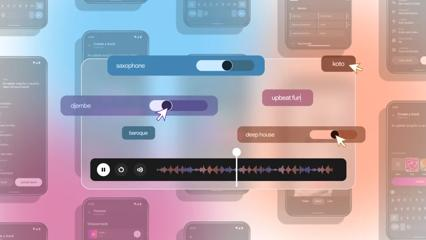

[Make funky beats with Google's MusicFX DJ](https://djmag.com/news/prompt-based-music-generative-ai-tool-musicfx-dj-launched-google) - DJ Mag

___

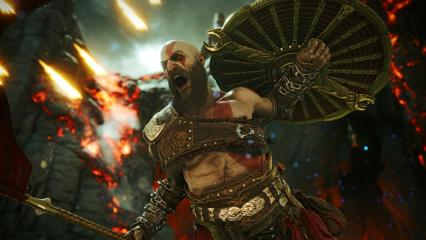

[Netflix closes expensive game studio, pivots to game dev using AI.](https://www.gamesradar.com/games/god-of-war/days-after-shutting-its-aaa-game-studio-filled-with-former-god-of-war-and-overwatch-talent-netflix-announces-a-new-initiative-powered-by-ai/) - gamesradar

___

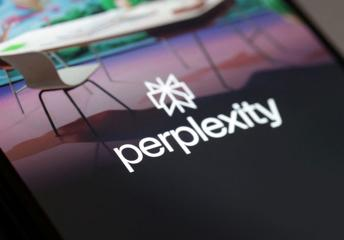

[Perplexity raising new funds at \\$9 billion valuation, source says](https://finance.yahoo.com/news/perplexity-raising-funds-9-billion-001035389.html) - Yahoo Finance

___

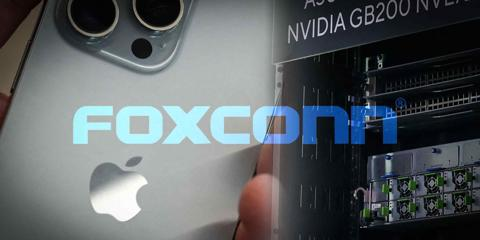

[Apple wants Foxconn to make AI servers but capacity is limited b/c they are making so many Nvidia AI servers](https://asia.nikkei.com/Business/Technology/Tech-Asia/Apple-asks-Foxconn-to-produce-servers-in-Taiwan-in-AI-push) - Nikkei Asia

___

[Using Chatgpt as a Angry BabyMama simulator.](https://www.reddit.com/r/ChatGPT/comments/1gjtl8x/using_chatgpt_as_a_angry_babymama_simulator/)

___

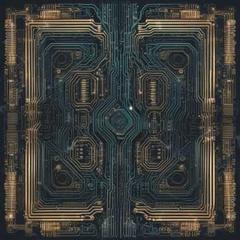

["I asked ChatGPT to give me the instructions to hack a system login and password in song. Then I fed it to Suno." (via reddit)](https://suno.com/song/051dae80-3031-42bb-b669-c8473a99bffc)

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [11]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [12]:
print(datetime.now())

2024-11-08 10:49:24.926918


In [13]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 11, 8, 15, 46, 0, 764000)

In [14]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-11-07 04:49:24.936230


In [15]:
from typing import TypedDict, Annotated

class Point2D(TypedDict, total=Falsee):
    x: int
    y: int
    label: str

a: Point2D = {'x': 1, 'y': 2, }  # 


NameError: name 'Falsee' is not defined

In [ ]:
a

In [ ]:
b

